In [ ]:
import pandas as pd
import dask
from dask import dataframe as daskdataframe
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Union
codes = {'h': 0, 'b': 1, 'f': 2, 'g': 3, 'd': 4, 'y': 5, 'a': 6, 'c': 7, 'e': 8}
codes_text = {v: k for k, v in codes.items()}

def create_balanced_sample(filename, chunk_size=300000, samples_per_class=1000):
    """
    Create a balanced sample from a large CSV file by taking equal samples from each class.
    
    Args:
        filename: Path to the CSV file
        chunk_size: Number of rows to process at a time
        samples_per_class: Number of samples to collect per class
        
    Returns:
        Balanced DataFrame with equal samples from each class
    """
    # Dictionary to store samples for each class
    class_samples = {}
    
    # First pass: identify all unique classes
    print("First pass: Identifying unique classes...")
    unique_classes = set()
    for chunk in pd.read_csv(filename, chunksize=chunk_size):
        unique_classes.update(chunk['label'].unique())
    
    # Initialize dictionary for each class
    for class_label in unique_classes:
        class_samples[class_label] = []
    
    # Second pass: collect samples for each class
    print(f"Second pass: Collecting {samples_per_class} samples per class...")
    for chunk in pd.read_csv(filename, chunksize=chunk_size):
        # For each class that still needs samples
        for class_label in unique_classes:
            if len(class_samples[class_label]) < samples_per_class:
                # Get class samples from current chunk
                class_data = chunk[chunk['label'] == class_label]
                needed = samples_per_class - len(class_samples[class_label])
                if len(class_data) > 0:
                    samples = class_data.sample(n=min(needed, len(class_data)))
                    class_samples[class_label].extend([samples])
        
        # Check if we have enough samples for all classes
        if all(len(samples) >= samples_per_class for samples in class_samples.values()):
            break
    
    # Combine all samples
    print("Combining samples...")
    balanced_samples = []
    for class_label, samples in class_samples.items():
        if samples:  # Check if we have any samples for this class
            class_df = pd.concat(samples, ignore_index=True)
            balanced_samples.append(class_df.head(samples_per_class))
    
    # Combine all classes and shuffle
    final_df = pd.concat(balanced_samples, ignore_index=True)
    final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print("\nFinal dataset statistics:")
    print(final_df['label'].value_counts())
    
    return final_df

def plot_sentence_lengths(
    df: pd.DataFrame,
    text_col: str = 'text',
    label_col: str = 'label_text',
    word_count_col='sentence_length',
    figsize: tuple = (14, 6),
    bins: int = 30,
    rotation: int = 45,
    log_scale: bool = False,
    palette: Optional[str] = None,
    show_stats: bool = True
) -> None:
    
    """
    Plots sentence length distributions by class and overall.
    
    Args:
        df: Input DataFrame containing text and labels
        text_col: Name of column containing text (default 'text')
        label_col: Name of column containing class labels (default 'label_text')
        figsize: Figure size (default (14, 6))
        bins: Number of bins for histograms (default 30)
        rotation: X-tick rotation for class labels (default 45)
        log_scale: Whether to use log scale for y-axis (default False)
        palette: Color palette for plots (default None)
        show_stats: Whether to print length statistics (default True)
    """
    # Calculate sentence lengths
    if isinstance(df, dask.dataframe.DataFrame):
        df = df.sample(frac=0.1).compute()
        
    if word_count_col == 'sentence_length':
        df = df.copy()
        df['sentence_length'] = df[text_col].apply(lambda x: len(str(x).split()))
    
    if show_stats:
        print("Sentence Length Statistics:")
        if isinstance(df, dask.dataframe.DataFrame):
            print(df.groupby(label_col)['sentence_length'].describe(meta=('description', 'object')))
        else:
            print(df.groupby(label_col)['sentence_length'].describe())
            
    
    # Set up figure
    plt.figure(figsize=figsize)
    
    # Plot 1: Overall distribution
    plt.subplot(1, 2, 1)
    sns.histplot(
        data=df,
        x=word_count_col,
        bins=bins,
        kde=True,
        color='skyblue' if palette is None else None,
        palette=palette
    )
    plt.title('Overall Sentence Length Distribution')
    plt.xlabel('Number of Words')
    if log_scale:
        plt.yscale('log')
        plt.ylabel('Frequency (log scale)')
    else:
        plt.ylabel('Frequency')
    
    # Plot 2: By-class distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(
        data=df,
        x=label_col,
        y=word_count_col,
        palette=palette
    )
    plt.title('Sentence Length by Class')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Words')
    plt.xticks(rotation=rotation)
    if log_scale:
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

    # Additional facet plot
    plt.figure(figsize=(12, 8))
    g = sns.FacetGrid(
        df,
        col=label_col,
        col_wrap=3,
        height=4,
        sharex=False,
        palette=palette
    )
    g.map(sns.histplot, word_count_col, bins=bins, kde=True)
    g.set_titles('{col_name}')
    g.fig.suptitle('Sentence Length Distribution by Class', y=1.02)
    plt.tight_layout()
    plt.show()

def draw_dist_binary_judgement(_df:Union[daskdataframe.DataFrame, pd.DataFrame],text):

    # Draw the distribution of binary_judgement
    plt.figure(figsize=(8, 6))
    if isinstance(_df, dask.dataframe.DataFrame):
        class_counts = _df['label_text'].value_counts().compute()
    else:
        class_counts = _df['label_text'].value_counts()
    print(class_counts.to_dict())
    class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(text)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.show()
  

def plot_label_distribution(df, figsize=(12, 6), name: str = "", label_column: str = 'label_text'):
    """
    Plot the distribution of labels in the dataset with count annotations.
    
    Parameters:
        df: DataFrame containing the data
        figsize: Tuple specifying figure size (default: (12, 6))
        name: Optional name to include in title (default: "")
        label_column: Name of the column containing labels (default: 'label')
    """
    plt.figure(figsize=figsize)
    plt.style.use('seaborn-v0_8-deep')
    
    # Create count plot
    ax = sns.countplot(data=df, x=label_column, order=df[label_column].value_counts().index)
    
    plt.title(f'Label Distribution {name}', pad=20)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add exact counts on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 5), 
                   textcoords='offset points')

    plt.show()
    

   
def process_df(df,category_codes):
    df["text"] = df["abstract"] #+ "\n " + df["description"]
    df = df.drop(columns=["abstract", "description","publication_number","application_number"])
    df["category_encoded"] = df["label"].apply(lambda x: category_codes[x])
    return df


# get random 900 points
def read_data_frame_statistic(path:str):
    df_small = pd.read_csv(path)
    plot_label_distribution(df_small,name=path)
    mean =df_small["text"].apply(lambda x: len(x.split())).mean()
    print(f"Mean text length: {mean}")
    print(f"Max text length: {df_small['text'].apply(lambda x: len(x.split())).max()}")
    print(f"Min text length: {df_small['text'].apply(lambda x: len(x.split())).min()}")
    print(df_small.describe())


## Dataset Load

In [11]:
paths = [
   # "train_data.csv",
   # "test_data.csv",
    "val_data.csv"
]
codes = {'h': 0, 'b': 1, 'f': 2, 'g': 3, 'd': 4, 'y': 5, 'a': 6, 'c': 7, 'e': 8}

for path in paths:
    chunks = pd.read_csv(f"../assets/bigPatentData/{path}",chunksize=50000)
    for i,df in enumerate(chunks):
        df['text'] = df['abstract'] + "\n " + df['description']
        df = df.drop(columns=['abstract', 'description', 'publication_number', 'application_number'])
        df['label_text']= df['label'].copy()
        df['label'] = df['label'].map(codes)
        df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
        df = df[df["word_count"] < 4000]
        if i == 0:
            df.to_csv(f"../assets/bigPatentData/{path.replace('.csv','_processed.csv')}",index=False)
        else:
            df.to_csv(f"../assets/bigPatentData/{path.replace('.csv','_processed.csv')}",mode='a',header=False,index=False)

## Balanced Test and Validation

Processing test_data_processed.csv
First pass: Identifying unique classes...
Second pass: Collecting 2000 samples per class...
Combining samples...

Final dataset statistics:
label
6    2000
5    2000
3    2000
7    2000
2    2000
1    2000
0    2000
8    1585
4     462
Name: count, dtype: int64
Sentence Length Statistics:
             count         mean         std    min      25%     50%      75%  \
label_text                                                                     
a           2000.0  2250.226000  853.063516  478.0  1611.00  2181.5  2890.25   
b           2000.0  2239.156500  803.663367  352.0  1626.50  2161.0  2828.50   
c           2000.0  2367.135000  836.998113  462.0  1736.00  2315.5  3035.25   
d            462.0  2251.205628  824.680175  437.0  1611.75  2212.5  2838.50   
e           1585.0  2288.665615  802.939719  410.0  1704.00  2245.0  2869.00   
f           2000.0  2237.340000  794.992440  439.0  1629.25  2171.0  2828.25   
g           2000.0  2481.826000  79

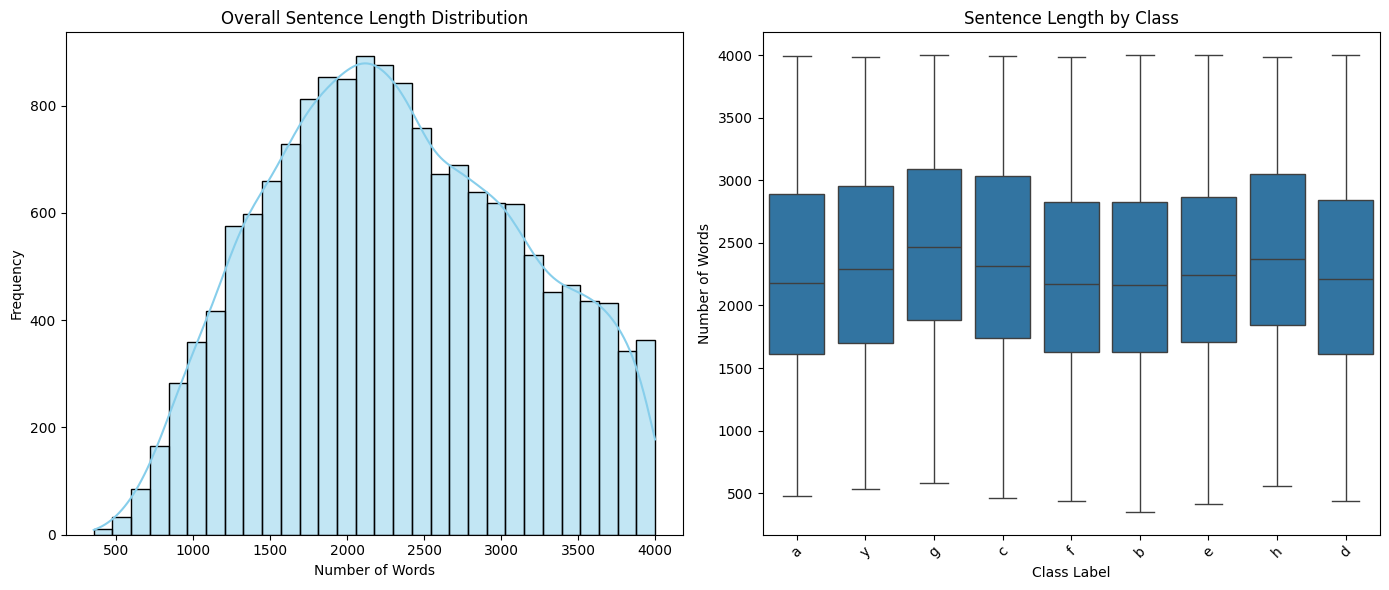

<Figure size 1200x800 with 0 Axes>

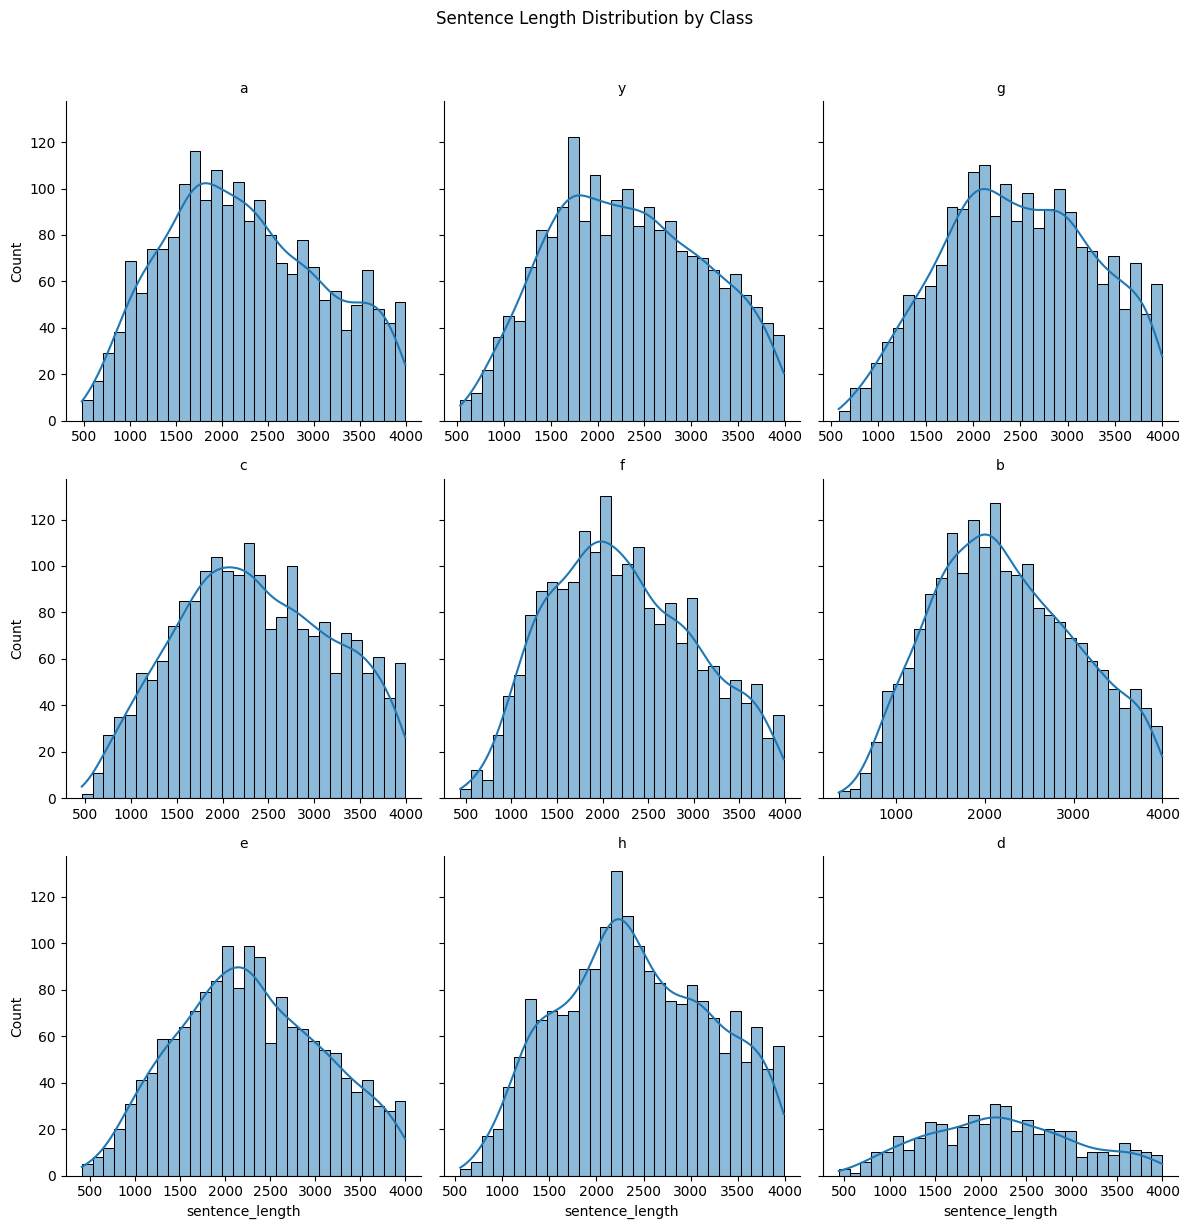

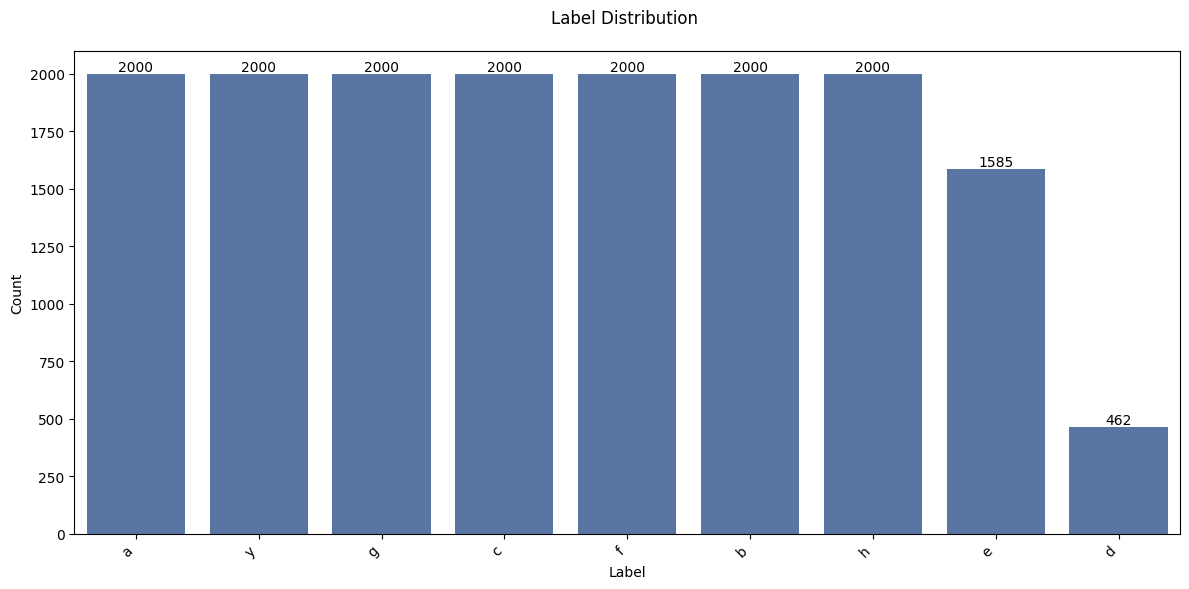

Processing val_data_processed.csv
First pass: Identifying unique classes...
Second pass: Collecting 2000 samples per class...
Combining samples...

Final dataset statistics:
label
3    2000
6    2000
7    2000
1    2000
0    2000
5    2000
2    2000
8    1607
4     462
Name: count, dtype: int64
Sentence Length Statistics:
             count         mean         std    min      25%     50%      75%  \
label_text                                                                     
a           2000.0  2285.201500  838.208961  437.0  1622.00  2229.5  2934.25   
b           2000.0  2235.104500  808.521926  455.0  1617.75  2158.0  2805.50   
c           2000.0  2407.690000  841.348134  416.0  1763.75  2362.0  3067.25   
d            462.0  2209.893939  814.870009  657.0  1598.25  2103.5  2744.50   
e           1607.0  2240.197262  796.415012  420.0  1624.50  2171.0  2807.50   
f           2000.0  2222.296500  782.203605  330.0  1630.00  2129.0  2773.25   
g           2000.0  2512.412000  802

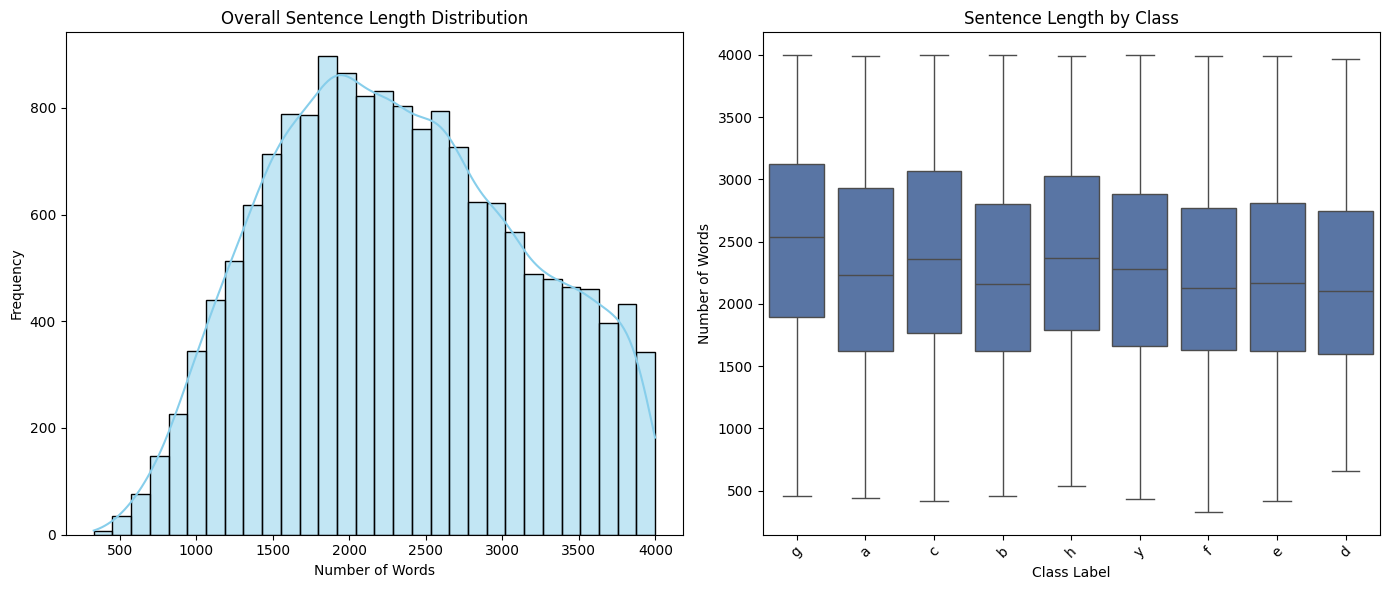

<Figure size 1200x800 with 0 Axes>

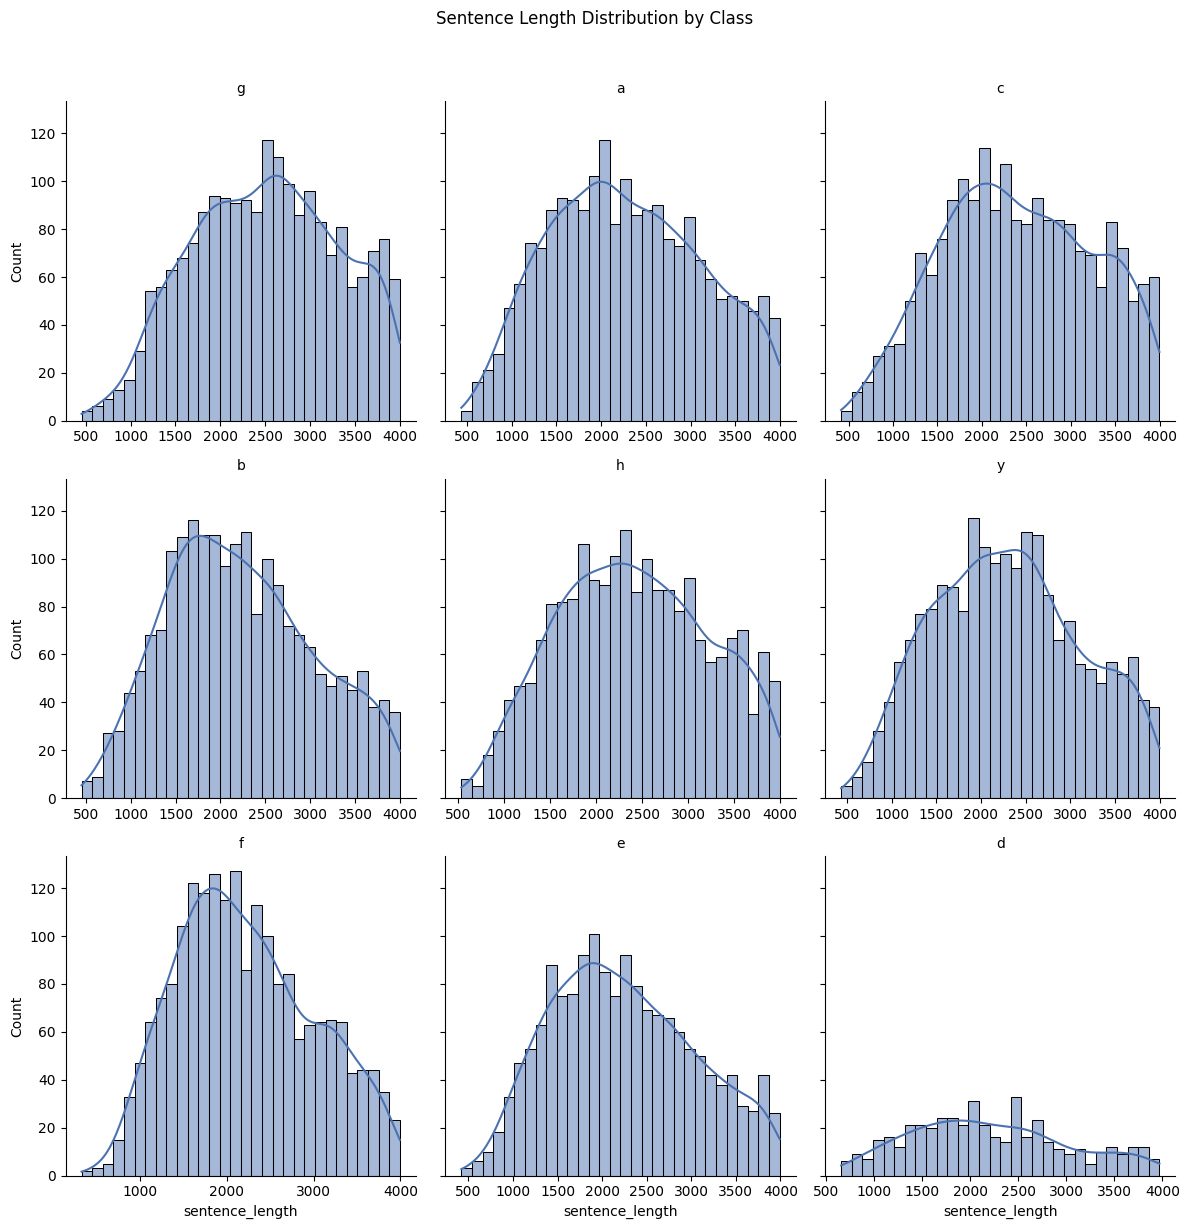

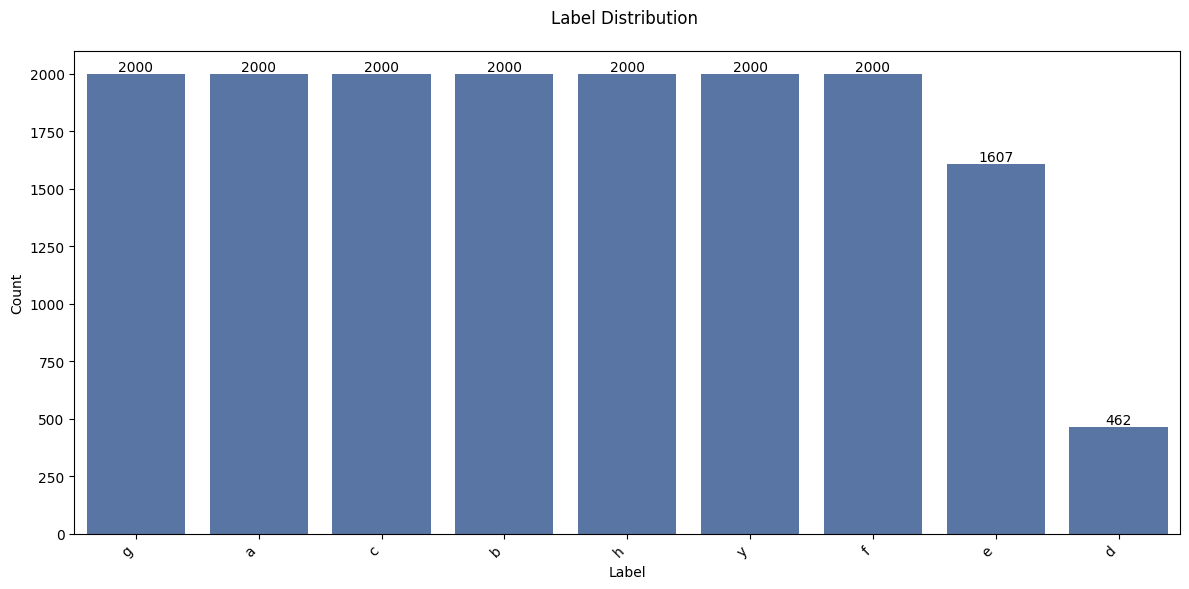

In [12]:
processed_paths = [
    #"train_data_processed.csv",
    "test_data_processed.csv",
    "val_data_processed.csv"
]

for p in processed_paths:
    print(f"Processing {p}")
    df = create_balanced_sample(f"../assets/bigPatentData/{p}", chunk_size=50000, samples_per_class=2000)
    plot_sentence_lengths(df)
    plot_label_distribution(df)
    df.to_csv(f"../data/processed/patent_balanced/patent90k_balanced_{p.replace('_data_processed.csv','')}.csv",index=False)

## Balanced Train

Processing train_data_processed.csv
First pass: Identifying unique classes...
Second pass: Collecting 10000 samples per class...
Combining samples...

Final dataset statistics:
label
0    10000
6    10000
3    10000
1    10000
2    10000
7    10000
8    10000
5    10000
4     8190
Name: count, dtype: int64
Sentence Length Statistics:
              count         mean         std    min      25%     50%     75%  \
label_text                                                                     
a           10000.0  2281.977900  832.815717  328.0  1629.75  2225.0  2913.0   
b           10000.0  2240.045400  797.547556  361.0  1620.75  2168.5  2822.0   
c           10000.0  2399.117300  848.439776  319.0  1738.00  2381.0  3087.0   
d            8190.0  2262.646398  806.263715  287.0  1632.00  2193.0  2856.0   
e           10000.0  2265.830200  806.399324  366.0  1636.00  2199.0  2862.0   
f           10000.0  2207.430300  794.942279  326.0  1595.00  2118.0  2774.0   
g           10000.0  248

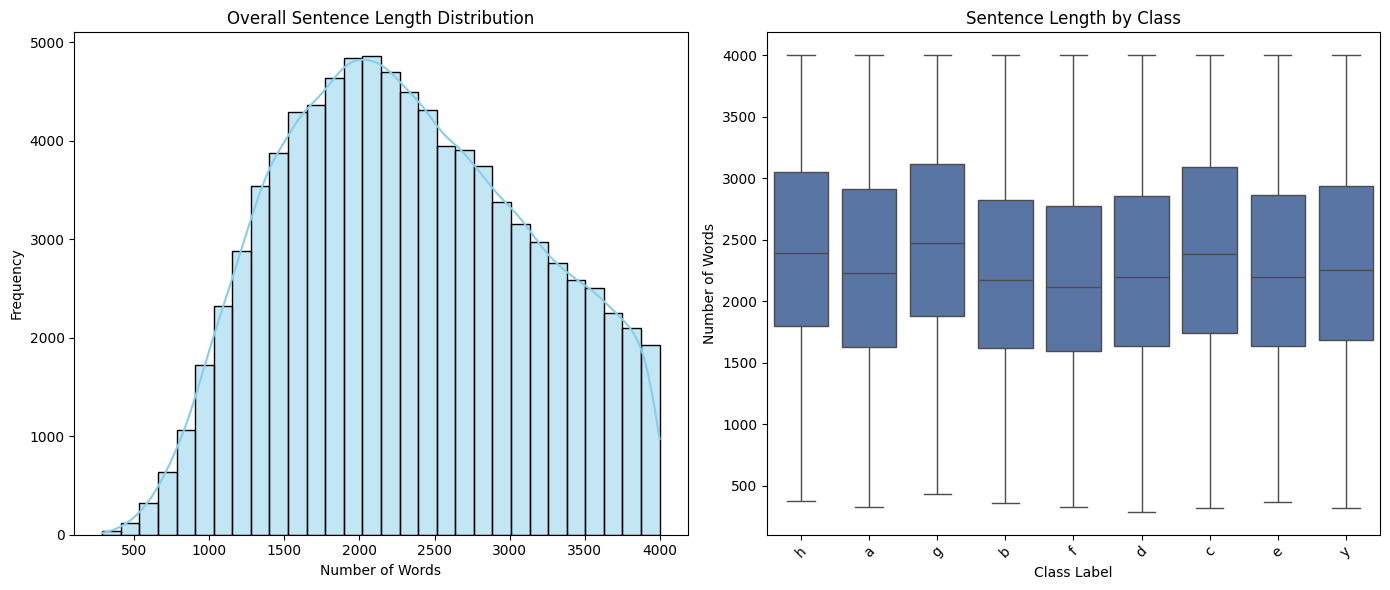

<Figure size 1200x800 with 0 Axes>

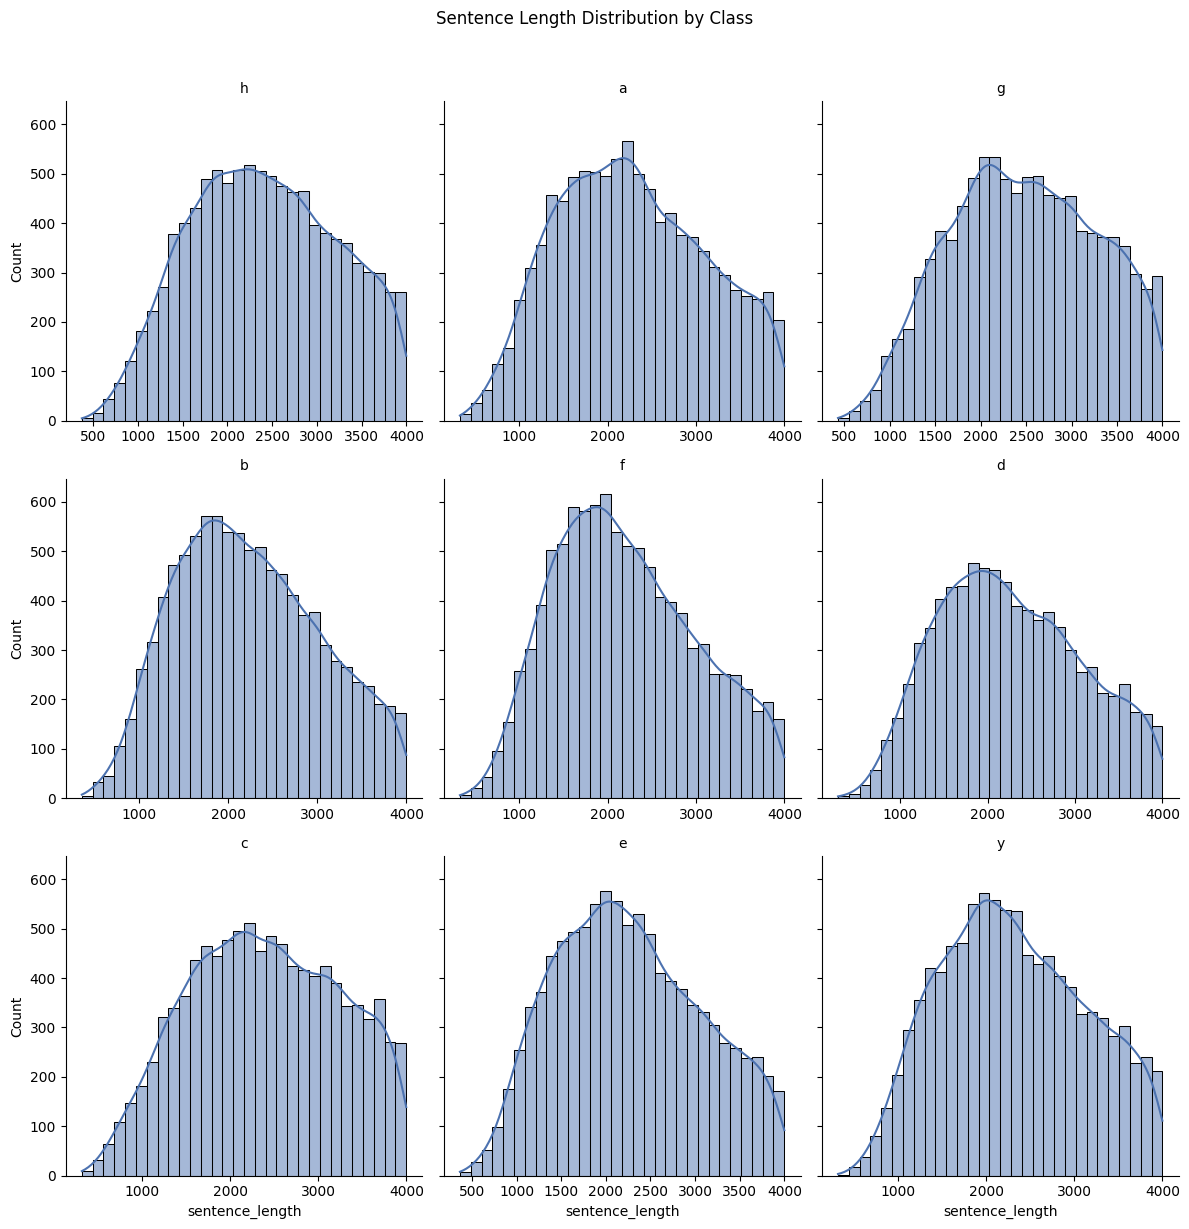

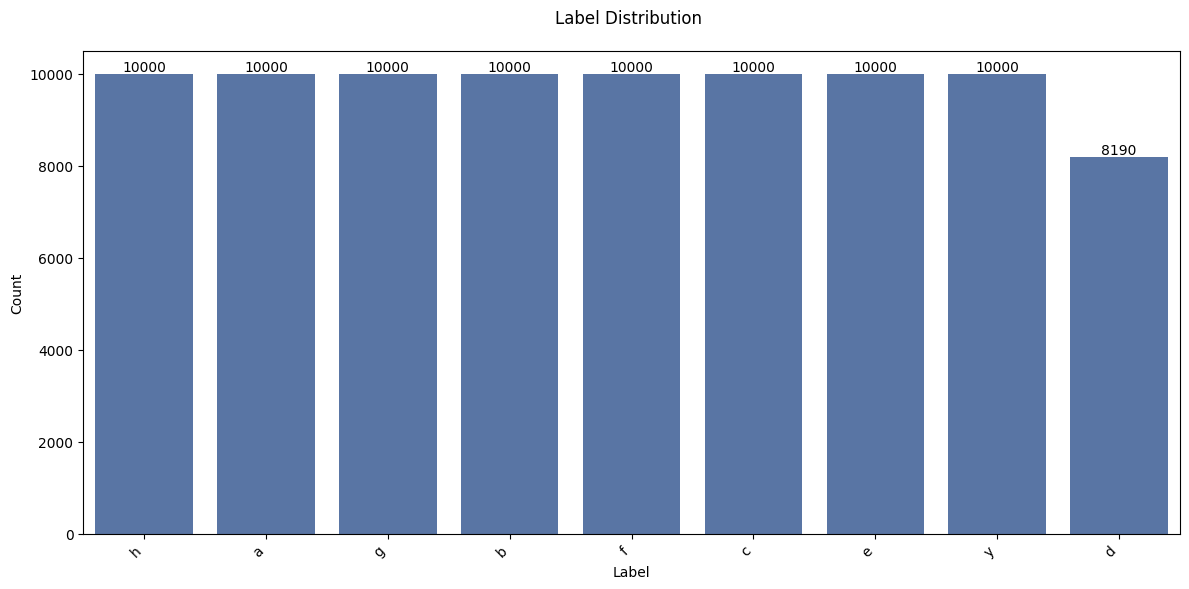

In [14]:
processed_paths = [
    "train_data_processed.csv",
]

for p in processed_paths:
    print(f"Processing {p}")
    df = create_balanced_sample(f"../assets/bigPatentData/{p}", chunk_size=50000, samples_per_class=10000)
    plot_sentence_lengths(df)
    plot_label_distribution(df)
    df.to_csv(f"../data/processed/patent_balanced/patent90k_balanced_{p.replace('_data_processed.csv','')}.csv",index=False)

In [19]:
<<<<<<< LOCAL CELL DELETED >>>>>>>

chunks = pd.read_csv("../assets/bigPatentData/train_data.csv",chunksize=100000)
codes = {'h': 0, 'b': 1, 'f': 2, 'g': 3, 'd': 4, 'y': 5, 'a': 6, 'c': 7, 'e': 8}
chunks

In [ ]:
paths = [
    "train_data.csv",
    "test_data.csv",
    "val_data.csv"
]
codes = {'h': 0, 'b': 1, 'f': 2, 'g': 3, 'd': 4, 'y': 5, 'a': 6, 'c': 7, 'e': 8}

for path in paths:
    chunks = pd.read_csv(f"../assets/bigPatentData/{path}",chunksize=50000)
    for i,df in enumerate(chunks):
        df['text'] = df['abstract'] + "\n " + df['description']
        df = df.drop(columns=['abstract', 'description', 'publication_number', 'application_number'])
        df['label_text']= df['label'].copy()
        df['label'] = df['label'].map(codes)
        df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
        df = df[df["word_count"] < 4000]
        if i == 0:
            df.to_csv(f"../assets/bigPatentData/{path.replace('data.csv','processed.csv')}",index=False)
        else:
            df.to_csv(f"../assets/bigPatentData/{path.replace('data.csv','processed.csv')}",mode='a',header=False,index=False)


# Balanced 90k

Processing test_processed.csv
First pass: Identifying unique classes...
Second pass: Collecting 2000 samples per class...
Combining samples...

Final dataset statistics:
label
6    2000
5    2000
3    2000
7    2000
2    2000
1    2000
0    2000
8    1585
4     462
Name: count, dtype: int64
Sentence Length Statistics:
             count         mean         std    min      25%     50%      75%  \
label_text                                                                     
a           2000.0  2261.640500  843.501926  478.0  1600.50  2171.0  2890.50   
b           2000.0  2230.034000  801.350400  438.0  1609.00  2155.0  2820.00   
c           2000.0  2394.862500  829.774603  382.0  1759.00  2351.0  3047.00   
d            462.0  2251.205628  824.680175  437.0  1611.75  2212.5  2838.50   
e           1585.0  2288.665615  802.939719  410.0  1704.00  2245.0  2869.00   
f           2000.0  2217.954000  787.817180  439.0  1599.75  2127.5  2785.00   
g           2000.0  2483.499500  801.019

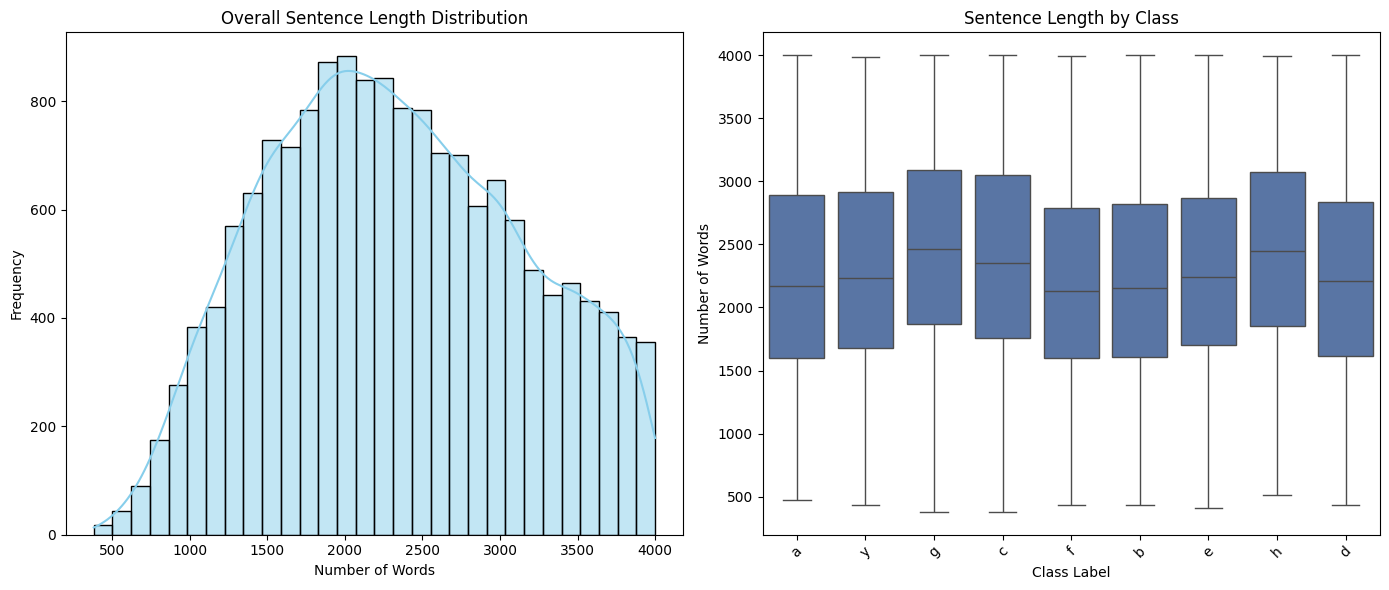

<Figure size 1200x800 with 0 Axes>

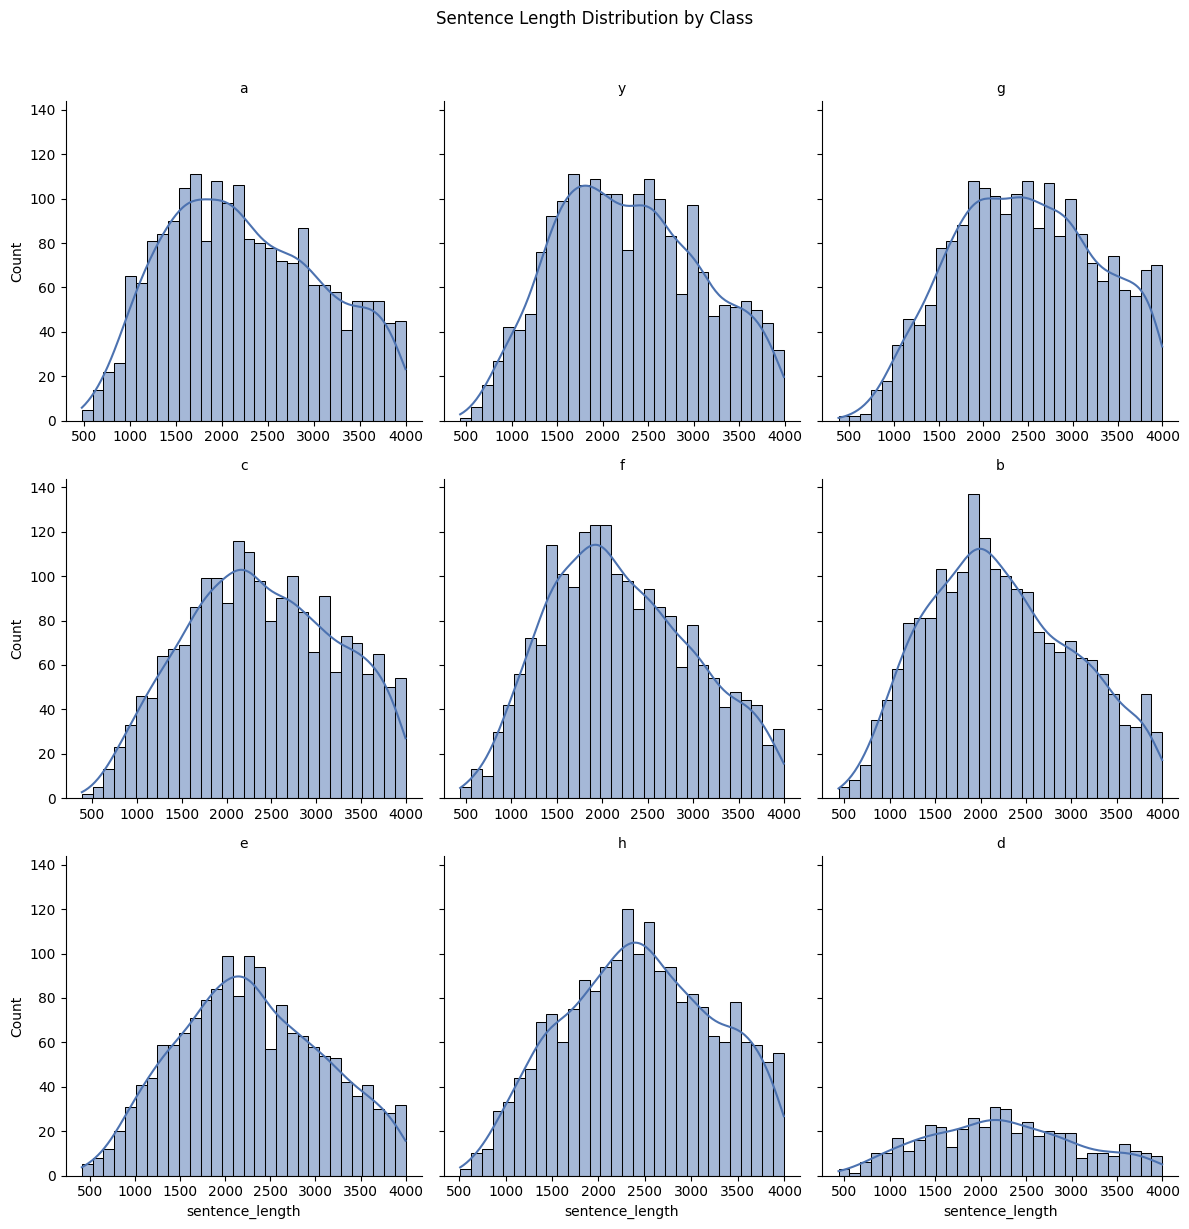

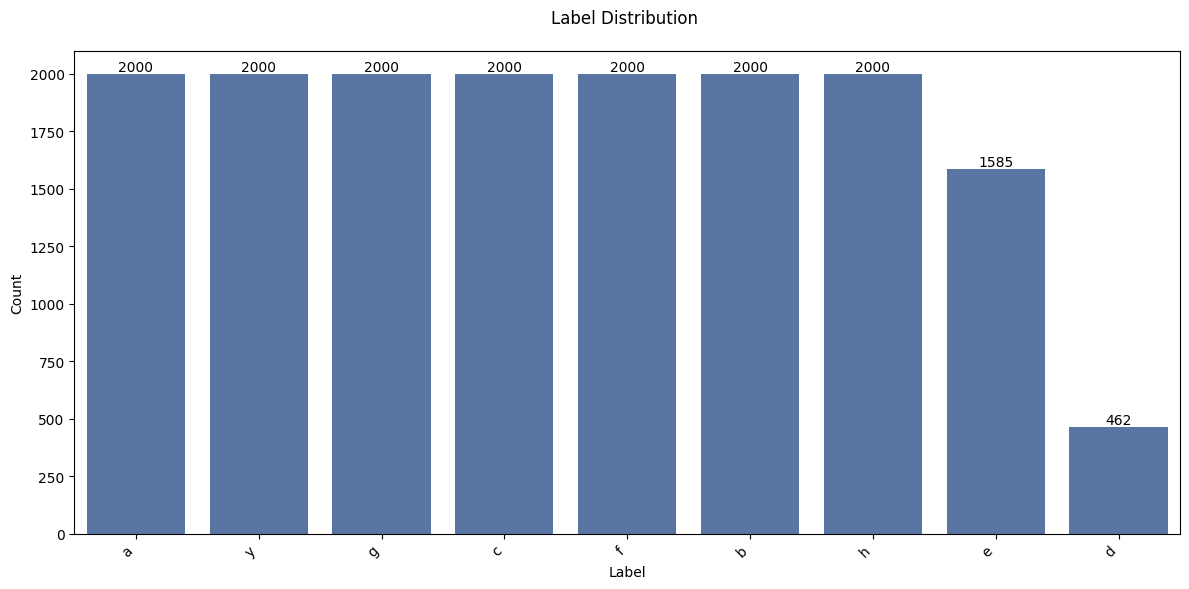

Processing val_processed.csv
First pass: Identifying unique classes...
Second pass: Collecting 2000 samples per class...
Combining samples...

Final dataset statistics:
label
3    2000
6    2000
7    2000
1    2000
0    2000
5    2000
2    2000
8    1607
4     462
Name: count, dtype: int64
Sentence Length Statistics:
             count         mean         std    min      25%     50%      75%  \
label_text                                                                     
a           2000.0  2273.651500  833.282313  325.0  1639.75  2176.0  2887.25   
b           2000.0  2246.444000  790.153057  473.0  1655.75  2151.0  2804.00   
c           2000.0  2387.832000  849.945873  253.0  1736.00  2339.5  3051.00   
d            462.0  2209.893939  814.870009  657.0  1598.25  2103.5  2744.50   
e           1607.0  2240.197262  796.415012  420.0  1624.50  2171.0  2807.50   
f           2000.0  2186.485000  811.284096  330.0  1576.00  2075.0  2797.00   
g           2000.0  2501.115000  815.6894

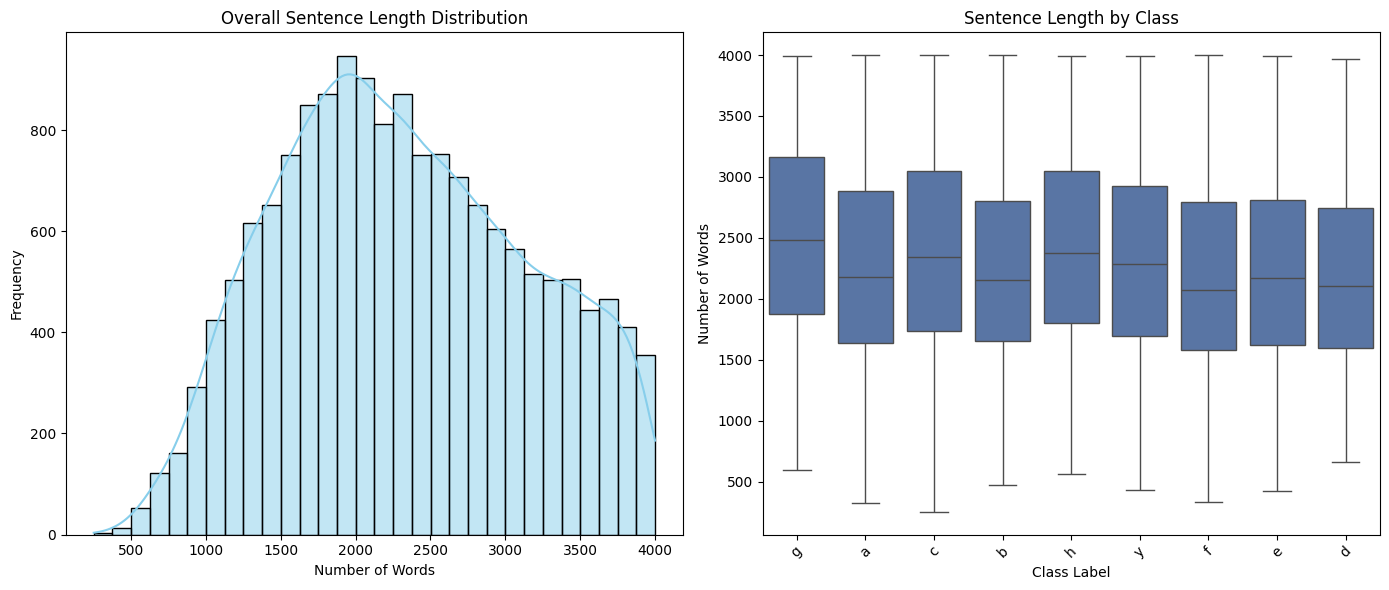

<Figure size 1200x800 with 0 Axes>

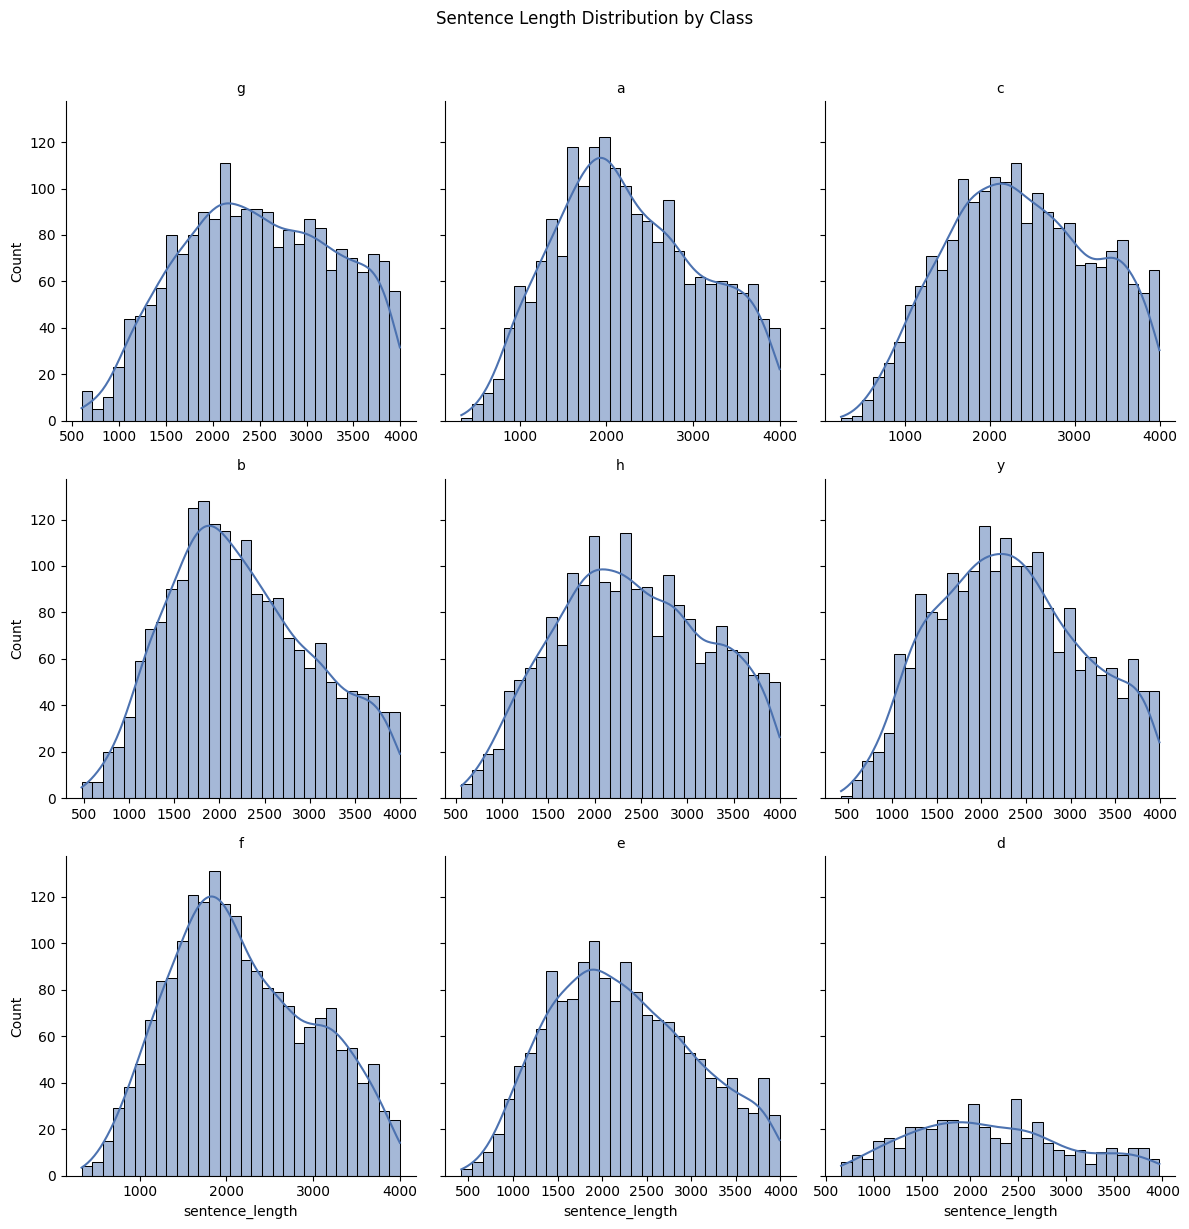

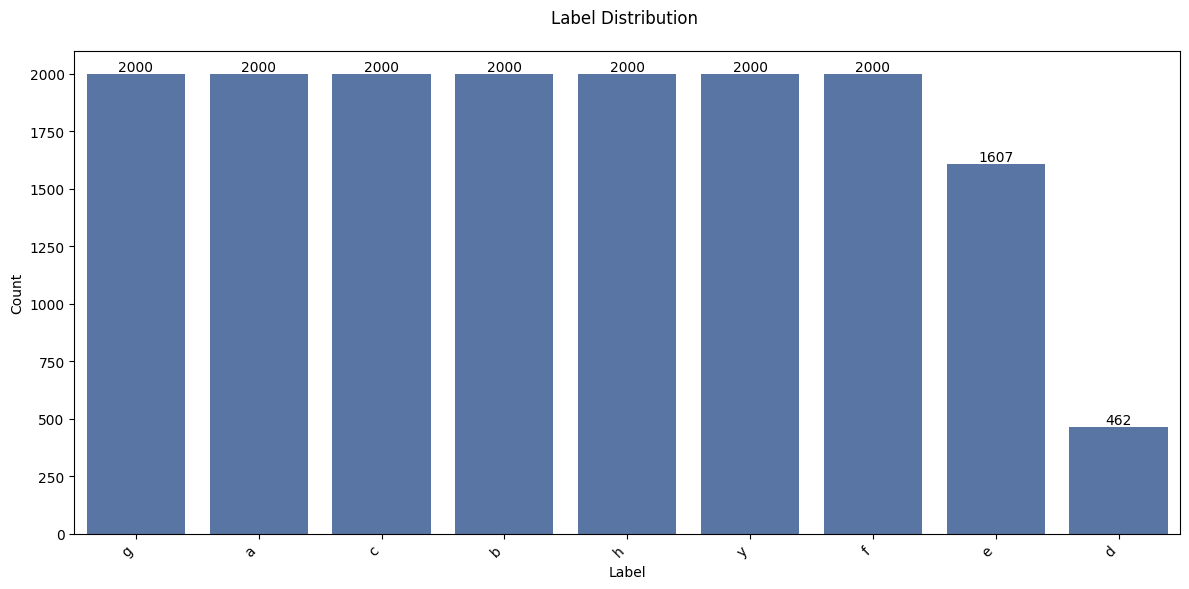

In [21]:
processed_paths = [
    "test_processed.csv",
    "val_processed.csv"
]

for p in processed_paths:
    print(f"Processing {p}")
    df = create_balanced_sample(f"../assets/bigPatentData/{p}", chunk_size=50000, samples_per_class=2000)
    plot_sentence_lengths(df)
    plot_label_distribution(df)
    df.to_csv(f"../data/processed/patent_balanced/patent90k_balanced_{p.replace('_processed.csv','')}.csv",index=False)

In [ ]:
# df.to_csv("../data/processed/patent_balanced/patent90k_balanced_train.csv",index=False)

##  Balanced Train set

Sentence Length Statistics:
              count         mean         std    min     25%     50%      75%  \
label_text                                                                     
a           10000.0  2286.502900  835.027682  328.0  1627.0  2228.5  2927.25   
b           10000.0  2237.376700  795.350926  361.0  1619.0  2165.0  2814.00   
c           10000.0  2403.141400  847.294879  319.0  1746.0  2381.5  3088.00   
d            8190.0  2262.646398  806.263715  287.0  1632.0  2193.0  2856.00   
e           10000.0  2257.272800  798.253275  283.0  1641.0  2183.5  2846.25   
f           10000.0  2208.894700  792.253216  383.0  1599.0  2118.0  2769.00   
g           10000.0  2485.314300  801.594415  423.0  1877.0  2478.0  3120.00   
h           10000.0  2428.772000  803.022410  373.0  1816.0  2395.5  3059.00   
y           10000.0  2317.241700  815.228607  314.0  1679.0  2261.0  2941.00   

               max  
label_text          
a           3999.0  
b           3999.0  
c      

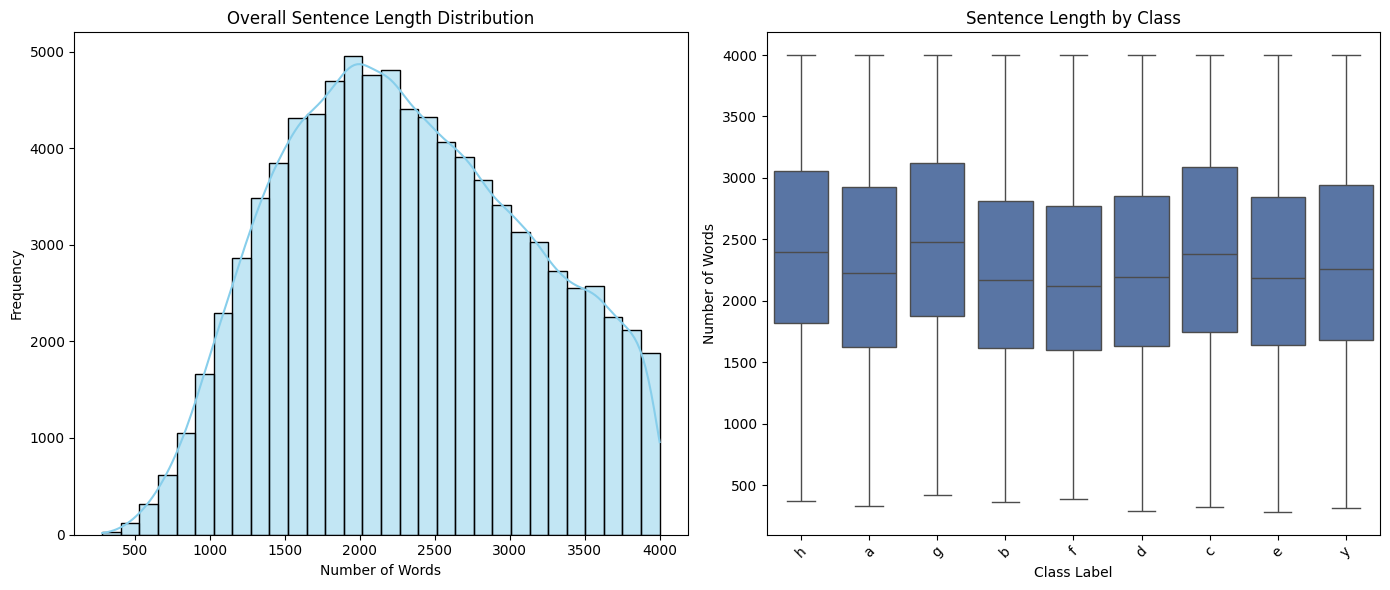

<Figure size 1200x800 with 0 Axes>

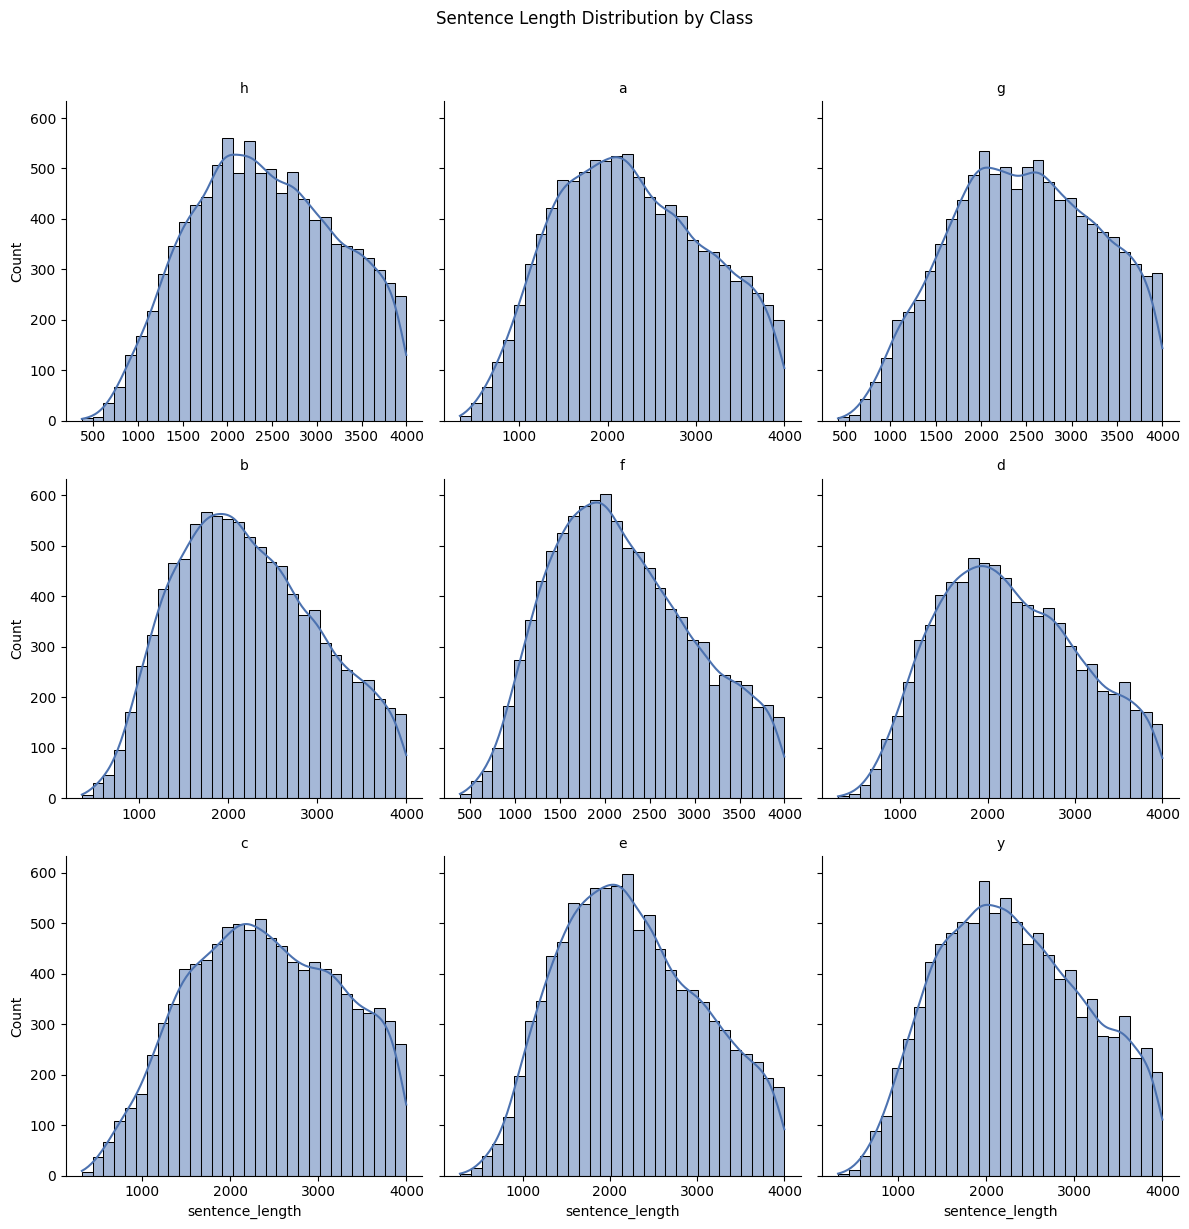

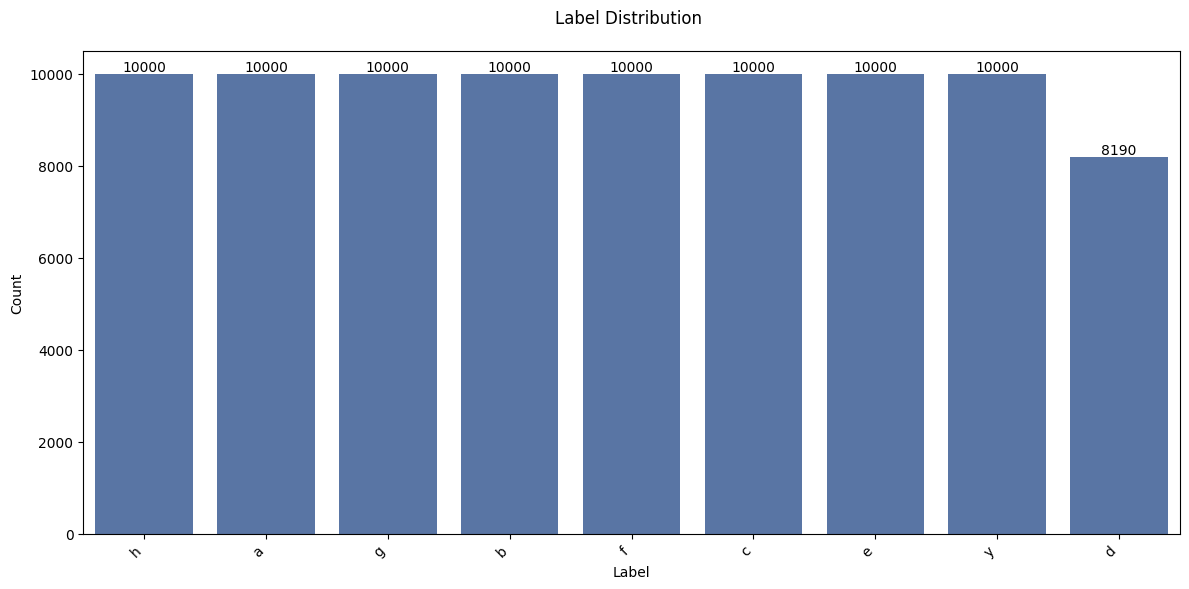

In [22]:
df = pd.read_csv(f"../data/processed/patent_balanced/patent90k_balanced_train.csv")
plot_sentence_lengths(df)
plot_label_distribution(df)

# HuggingFace Patent Classification Dataset

https://huggingface.co/datasets/ccdv/patent-classification

In [1]:
import pandas as pd


splits = {'train': 'abstract/train-00000-of-00001.parquet', 'validation': 'abstract/validation-00000-of-00001.parquet', 'test': 'abstract/test-00000-of-00001.parquet'}

def get_split_data(split:str):
    df = pd.read_parquet("hf://datasets/ccdv/patent-classification/" + splits[split])
    df["label_text"]= df["label"].map(codes_text)
    return df


In [2]:
for split in splits.keys():
    df = get_split_data(split)
    df.to_csv(f"../data/processed/patent/patent_{split}.csv",index=False)
    del df

## Train Dataset

In [16]:
dftrain = pd.read_csv("../data/processed/patent/patent_train.csv")
dftrain

,text,label,label_text
0,an apparatus for simultaneously testing multip...,6,a
1,an electrosurgical instrument includes a housi...,0,h
2,a wireless transceiver device employing the co...,7,c
3,the invention provides for the use of protein ...,0,h
4,the present invention relates to a device for ...,8,e
...,...,...,...
24995,a security tag having a lanyard member that en...,6,a
24996,in a liquid crystal display device into which ...,6,a
24997,the present invention provides a process for t...,2,f
24998,ceiling fan energy consumption efficiency is e...,5,y


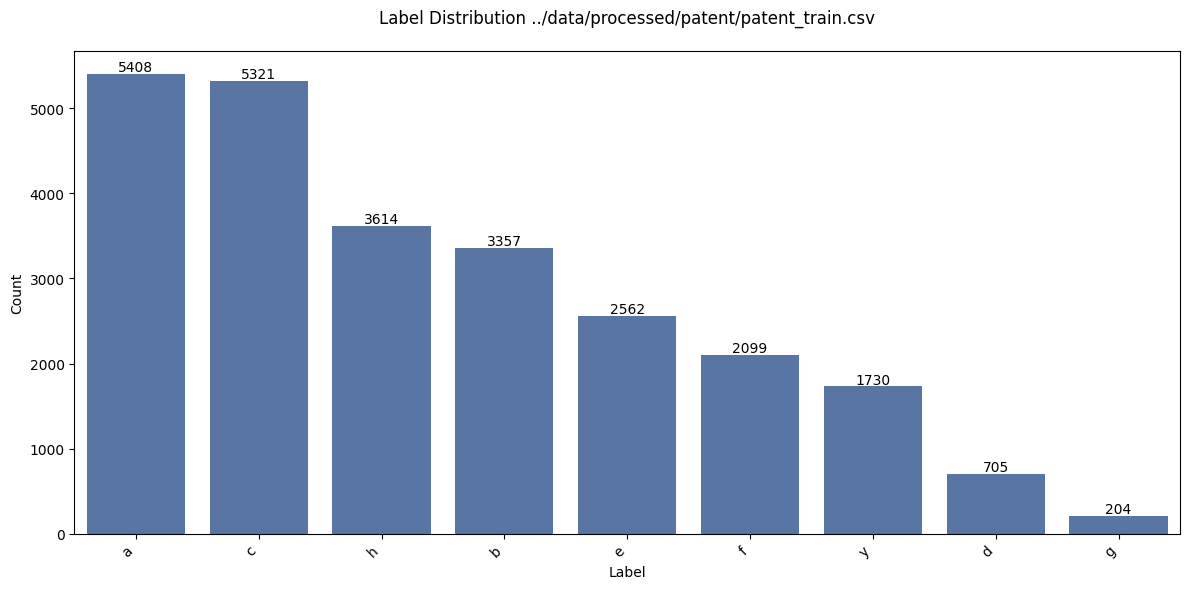

Mean text length: 116.19956
Max text length: 595
Min text length: 12
              label
count  25000.000000
mean       4.393120
std        2.863736
min        0.000000
25%        1.000000
50%        6.000000
75%        7.000000
max        8.000000


In [47]:
read_data_frame_statistic("../data/processed/patent/patent_train.csv")

Sentence Length Statistics:
             count        mean        std   min    25%    50%     75%    max
label_text                                                                  
a           5408.0  123.621302  49.592418  19.0  88.00  120.0  154.00  424.0
b           3357.0  114.892166  49.271580  12.0  79.00  109.0  145.00  382.0
c           5321.0  120.554031  47.606420  19.0  86.00  117.0  151.00  588.0
d            705.0  118.931915  47.531938  20.0  84.00  117.0  148.00  296.0
e           2562.0  115.293521  50.610383  14.0  78.00  111.0  146.00  442.0
f           2099.0  100.256313  61.042719  17.0  57.00   89.0  127.50  595.0
g            204.0  108.470588  51.867433  25.0  70.75  100.0  137.25  326.0
h           3614.0  109.818484  50.026871  20.0  72.00  104.0  141.00  396.0
y           1730.0  115.956647  48.573424  21.0  81.00  110.0  145.00  381.0


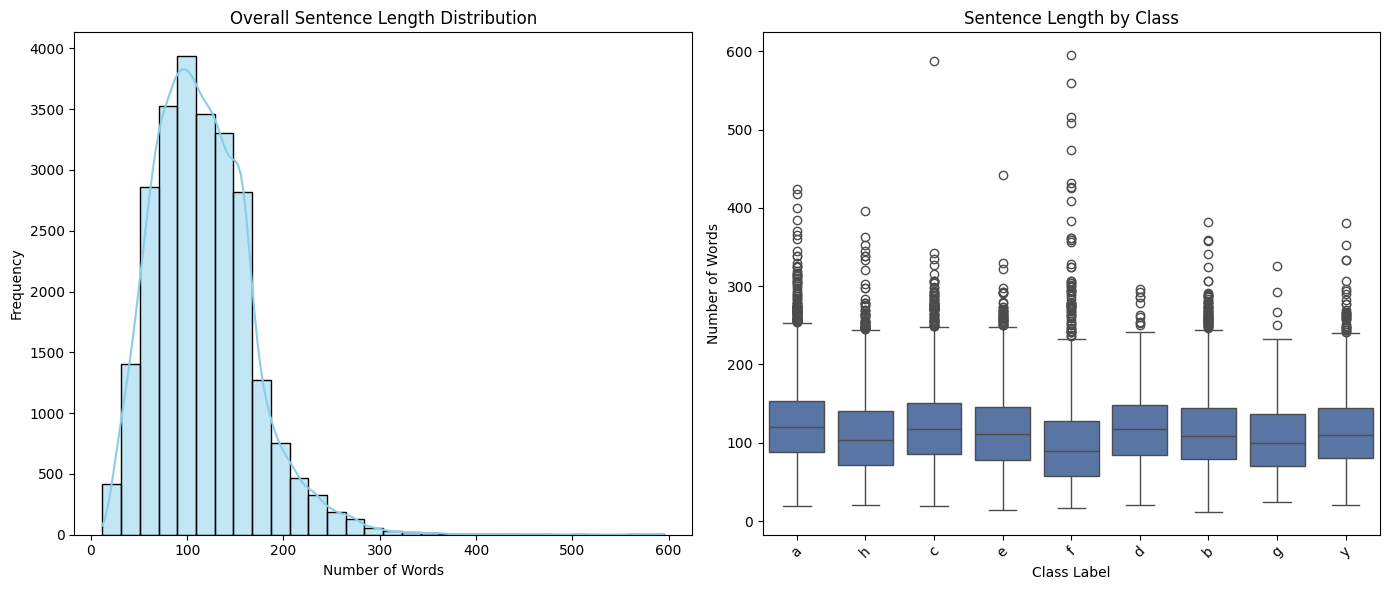

<Figure size 1200x800 with 0 Axes>

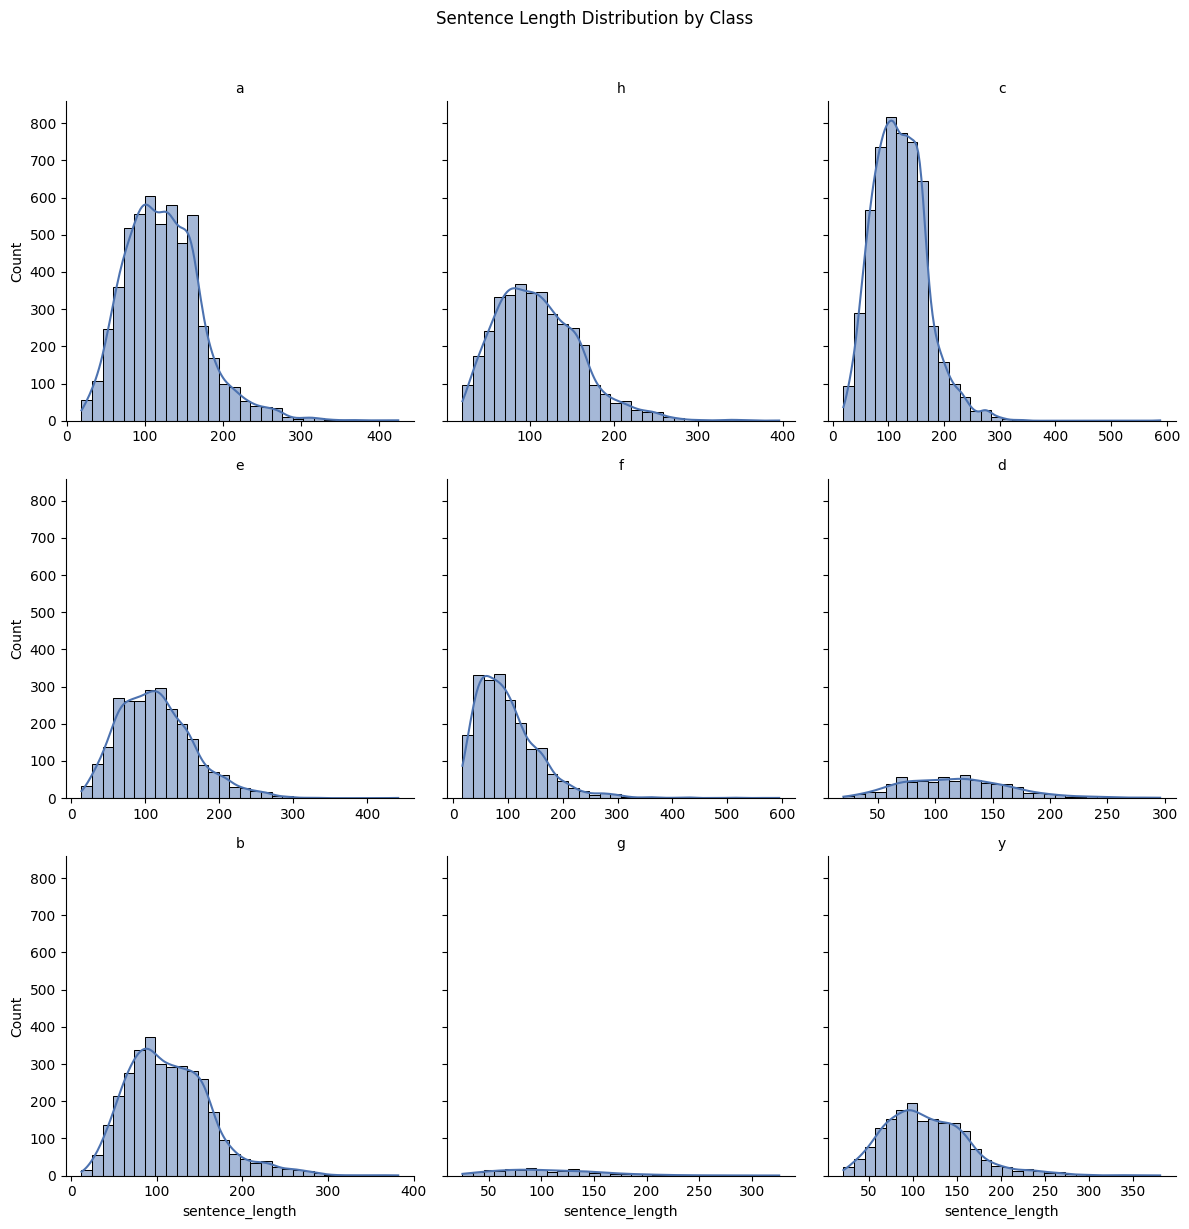

In [23]:
plot_sentence_lengths(dftrain)

{'a': 5408, 'c': 5321, 'h': 3614, 'b': 3357, 'e': 2562, 'f': 2099, 'y': 1730, 'd': 705, 'g': 204}


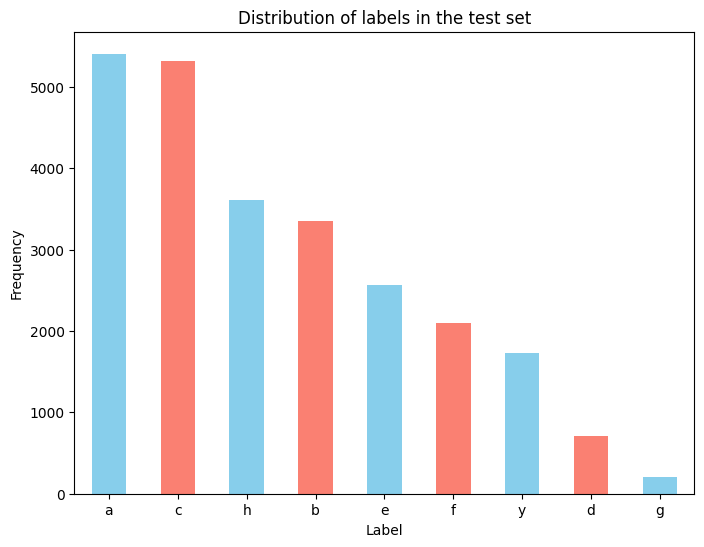

In [24]:
draw_dist_binary_judgement(dftrain, "Distribution of labels in the train set")

## Test Dataset